### TARGET DETERMINATION : METHOD ONE

For this experiment, we would try to determine the distribution of price displacement, relative to a multiple of the current state, over a period of time. 
The current state can be define by any parameter. We would be using the Average True Range. The data we would use for this experiment would be AAPL Hourly Data from 2010 - 2023.

The goal of this experiment is to determine a target that has a high probability of getting hit.

Procedure : 
- Calculate the current ATR values

- Compute the price distribution over the selected period of time. Compute the max drawdown and runup

In [20]:
# Import the data
import pandas as pd
from pathlib import Path
import pandas_ta as ta
import quantstats as qt #noqa
import numpy as np
import seaborn as sns #noqa
import matplotlib.pyplot as plt

aapl_path = Path.cwd().parent / 'data/aapl_h1.csv'
btc_path = Path.cwd().parent / 'data/btcusdt_h1.parquet'

In [21]:
# Prepare Data
# raw_data = pd.read_parquet(btc_path)
# raw_data.reset_index(names=['datetime'], inplace=True)

raw_data = pd.read_csv(aapl_path)
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
raw_data

,datetime,open,high,low,close,volume
0,1998-01-02 16:00:00,0.12,0.12,0.12,0.12,14512400
1,1998-01-02 17:00:00,0.12,0.13,0.12,0.12,52987312
2,1998-01-02 18:00:00,0.12,0.13,0.12,0.13,23746800
3,1998-01-02 19:00:00,0.13,0.13,0.13,0.13,21644000
4,1998-01-02 20:00:00,0.13,0.13,0.13,0.13,11933600
...,...,...,...,...,...,...
46337,2023-12-28 19:00:00,194.21,194.22,193.89,194.13,2513664
46338,2023-12-28 20:00:00,194.13,194.43,193.89,193.98,2082974
46339,2023-12-28 21:00:00,193.98,193.98,193.58,193.87,2542583
46340,2023-12-28 22:00:00,193.88,194.09,193.87,193.97,1881975


In [22]:
# Parameters
lookahead = 10
atr_length = 14
ema_length = 100

In [23]:
# Filter the date range
data = raw_data[(raw_data['datetime'].dt.year >= 2010) & (raw_data['datetime'].dt.year <= 2023)]
data = data.reset_index(drop=True)

# Feature Engineering
data['atr'] = ta.atr(data['high'], data['low'], data['close'], atr_length)
data['atr_ratio'] = data['atr'] / data['close'].shift(1)
returns = data['close'].pct_change().fillna(0)

# Moving Average
data['ema'] = ta.ema(data['close'], ema_length)

# Handle Outlier : Replace with the mean
mean_return = np.mean(returns)
returns.loc[returns.abs() > np.percentile(returns.abs(), 99)] = mean_return # Replace outliers: returns greater than 99th percentile

data['next_returns'] = returns.shift(-1)
data['lookahead_return'] = data['next_returns'].rolling(lookahead).sum().shift(-lookahead) # Gets the return from the next [lookback] bars
data['max_drawdown'] = data['next_returns'].rolling(lookahead).apply(lambda x : qt.stats.max_drawdown(x)).shift(-lookahead) # Gets the max drawdown from the next [lookback] bars
data['max_runup'] = data['next_returns'].rolling(lookahead).apply(lambda x : max(np.cumsum(x))).shift(-lookahead) # Gets the max drawdown from the next [lookback] bars

# Calculate the distributions
data['returns_atr_ratio'] = data['lookahead_return'] / data['atr_ratio'] # Total returns over the lookahead period
data['rar_smooth'] = ta.ema(data['returns_atr_ratio'], 50) # Smoothen the distribution

data['dd_atr_ratio'] = data['max_drawdown'] / data['atr_ratio']
data['ru_atr_ratio'] = data['max_runup'] / data['atr_ratio']

# Drop NaNs
data = data.dropna(axis=0)

# Print Sample
display(data.shape)
data.sample(5)

(25142, 17)

,datetime,open,high,low,close,volume,atr,atr_ratio,ema,next_returns,lookahead_return,max_drawdown,max_runup,returns_atr_ratio,rar_smooth,dd_atr_ratio,ru_atr_ratio
3455,2011-12-15 20:00:00,13.55,13.58,13.54,13.56,4705659,0.085884,0.006338,13.794747,-0.001475,0.010400,-0.006584,0.014766,1.640750,-0.876502,-1.038723,2.329704
16184,2019-03-13 17:00:00,45.43,45.48,45.23,45.40,4128887,0.290262,0.006391,43.729751,0.000661,0.011021,-0.004819,0.011672,1.724483,1.134806,-0.754117,1.826490
17911,2020-03-04 22:00:00,74.76,75.74,74.59,75.70,8448696,1.494472,0.019988,74.854908,0.000354,-0.004844,-0.015990,0.007582,-0.242359,0.005222,-0.800012,0.379331
7314,2014-02-28 16:00:00,18.89,18.99,18.84,18.97,11391709,0.111585,0.005923,18.865147,-0.005799,-0.005766,-0.011634,0.002651,-0.973583,-0.089221,-1.964298,0.447615
20483,2021-08-10 17:00:00,147.43,147.63,145.63,145.92,11288532,0.661163,0.004485,146.227411,-0.002056,0.002967,-0.003149,0.004744,0.661522,-0.351624,-0.702173,1.057779


In [24]:
data.head()

,datetime,open,high,low,close,volume,atr,atr_ratio,ema,next_returns,lookahead_return,max_drawdown,max_runup,returns_atr_ratio,rar_smooth,dd_atr_ratio,ru_atr_ratio
99,2010-01-25 17:00:00,7.26,7.28,7.20,7.27,34695521,0.082462,0.011358,7.496000,-0.013755,0.042865,-0.014493,0.057358,3.773831,-1.211785,-1.275944,5.049775
100,2010-01-25 18:00:00,7.27,7.27,7.14,7.17,33145070,0.085858,0.011810,7.489545,0.008368,0.017117,-0.031621,0.048989,1.449380,-1.107425,-2.677462,4.148170
101,2010-01-25 19:00:00,7.17,7.24,7.17,7.23,18840927,0.084725,0.011817,7.484405,0.004149,0.011607,-0.032938,0.044840,0.982269,-1.025476,-2.787434,3.794659
102,2010-01-25 20:00:00,7.23,7.27,7.22,7.26,17869635,0.082245,0.011376,7.479961,0.005510,-0.002077,-0.040843,0.039330,-0.182578,-0.992422,-3.590454,3.457469
103,2010-01-25 21:00:00,7.26,7.30,7.25,7.30,25690308,0.079942,0.011011,7.476398,-0.009589,0.004765,-0.043478,0.048919,0.432727,-0.936533,-3.948531,4.442683


In [25]:
def get_distribution(data, title):
    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    
    print("Mean : ", mean)
    print("Standard Deviation : ", std)
    
    # Plot the distribution
    plt.hist(data, bins=30, color='lightblue', edgecolor='black') 

    # Add vertical line at the median using plt.axvline
    plt.axvline(x=mean, color='blue', linestyle='--', label='Mean')
    plt.axvline(x=median, color='red', linestyle='--', label='Median')

    # Customization
    plt.title(f"Distribution of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()  # Show the label

    plt.show() 

### TEST SCENARIO 0 : GENERAL DISTRIBUTION (RETURNS AND DRAWDOWNS)
These are the distributions of the returns, and drawdowns from the general data

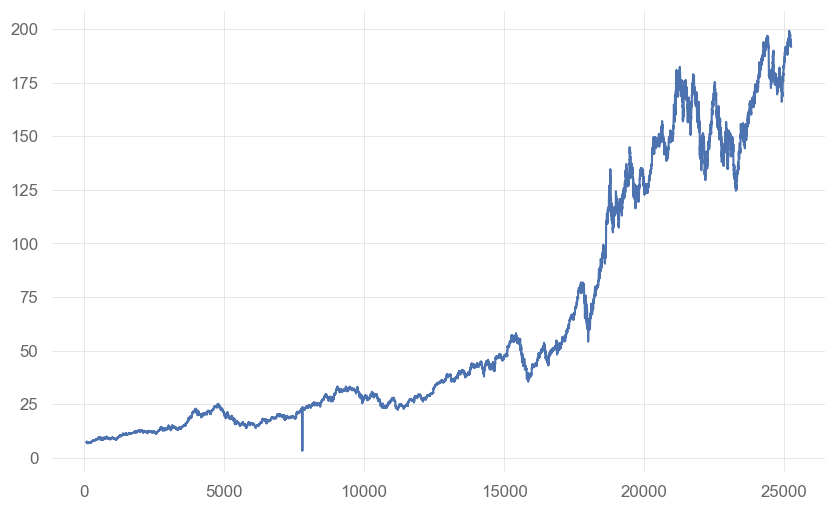

In [26]:
plt.plot(data['close'])

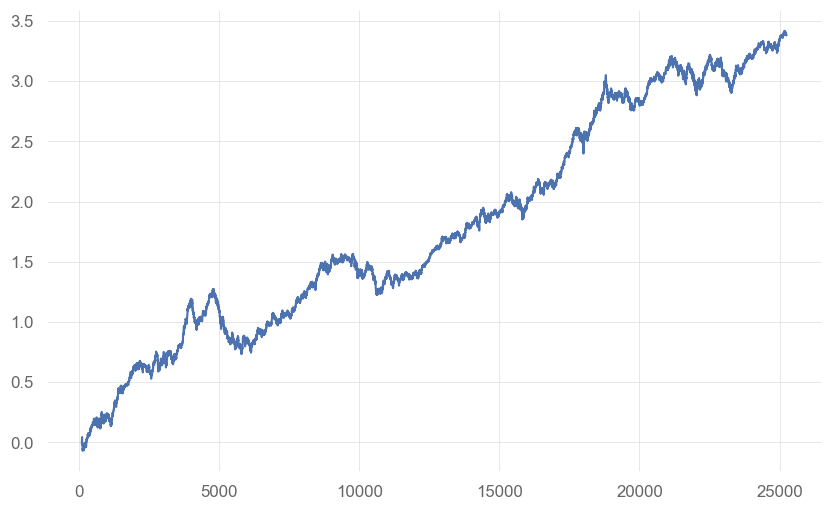

In [27]:
plt.plot(np.cumsum(data['next_returns']))

Mean :  0.0013440442398870878
Standard Deviation :  0.01672519755430379


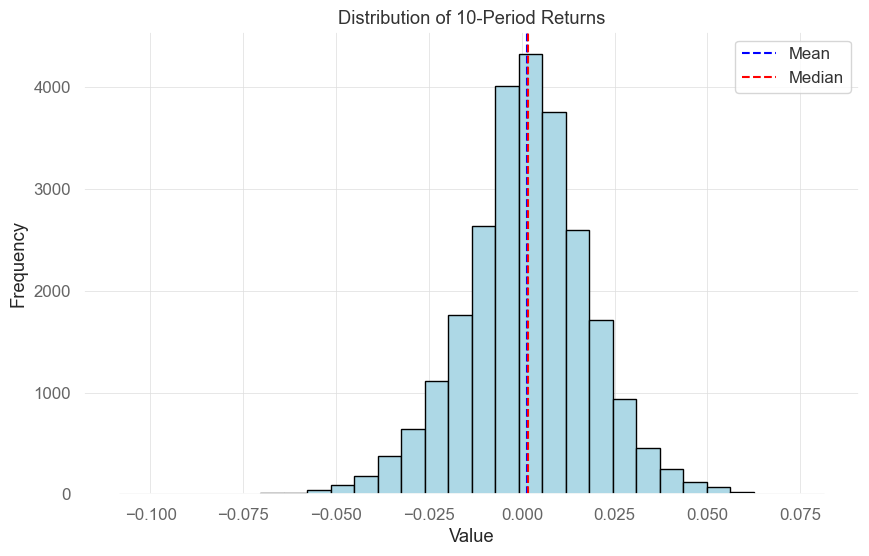

In [28]:
get_distribution(data['lookahead_return'], f'{lookahead}-Period Returns')

Mean :  -0.011804020170600907
Standard Deviation :  0.009663822299898442


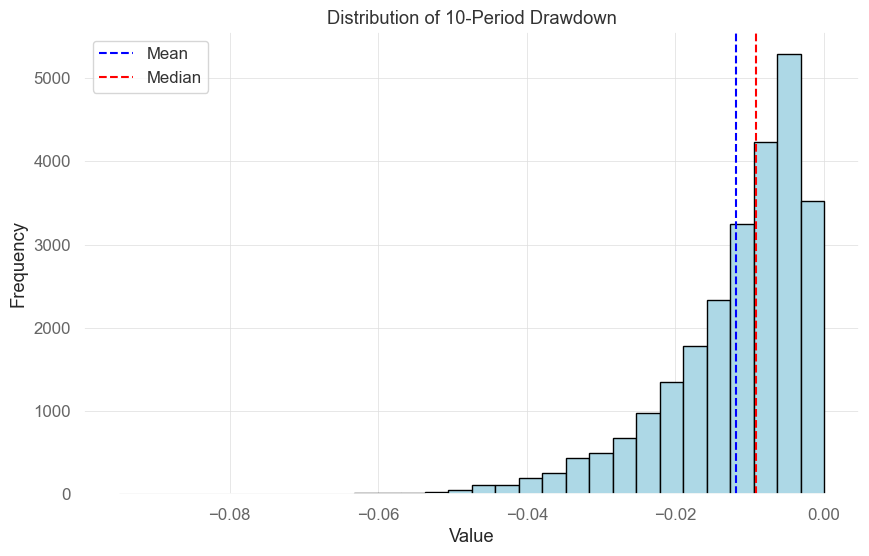

In [29]:
get_distribution(data['max_drawdown'], f'{lookahead}-Period Drawdown')

Mean :  0.009534639117414617
Standard Deviation :  0.011128173418202613


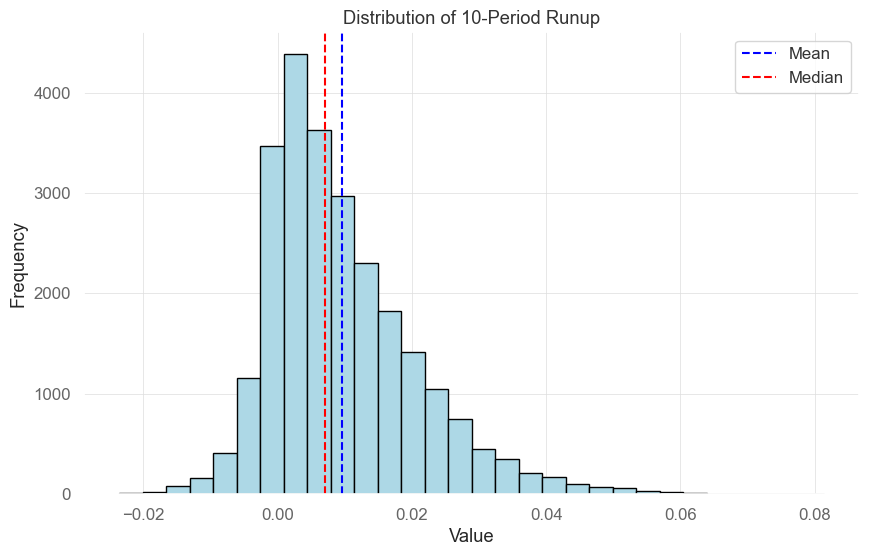

In [30]:
get_distribution(data['max_runup'], f'{lookahead}-Period Runup')

#### CONCLUSIONS
- Returns are evenly distributed. It is slightly positively skewed, but this is not significant
- Lookback period returns are normally distributed.
- Maximum drawdown has usually (over 85% of the times) within 2 STD of the max_drawdown. 

- 

### TEST SCENARIO 1 : CONDITIONAL DISTRIBUTION (RETURNS AND DRAWDOWNS)
These are the distributions of the returns, and drawdowns from the data, with regards to a selected condition (strategy). 

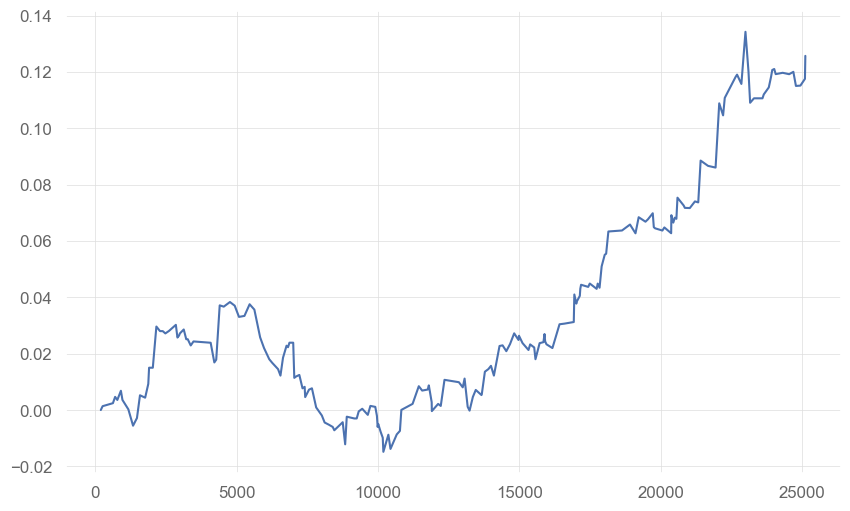

In [31]:
# Strategy Condition Definition : Simple Moving Average Cross
ema_21 = ta.ema(data['close'], 21)
ema_50 = ta.ema(data['close'], 50)
ema_cross_above = ta.cross(ema_21, ema_50, above=True, asint=True)
ema_cross_below = ta.cross(ema_21, ema_50, above=False, asint=True)

conditional_data = data[ema_cross_above == 1]
# conditional_data = data[(data['returns_atr_ratio'] < data['rar_smooth']) & (data['close'] < data['ema'])]
plt.plot(np.cumsum(conditional_data['next_returns']))

Mean :  0.002617621607793932
Standard Deviation :  0.016046923524443864


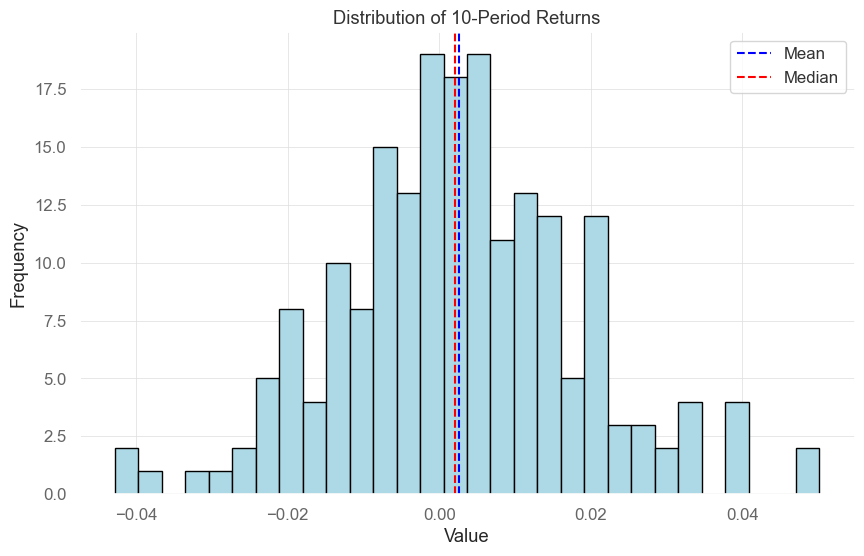

In [32]:
get_distribution(conditional_data['lookahead_return'], f'{lookahead}-Period Returns')

Mean :  -0.010804404196064515
Standard Deviation :  0.008580983524905642


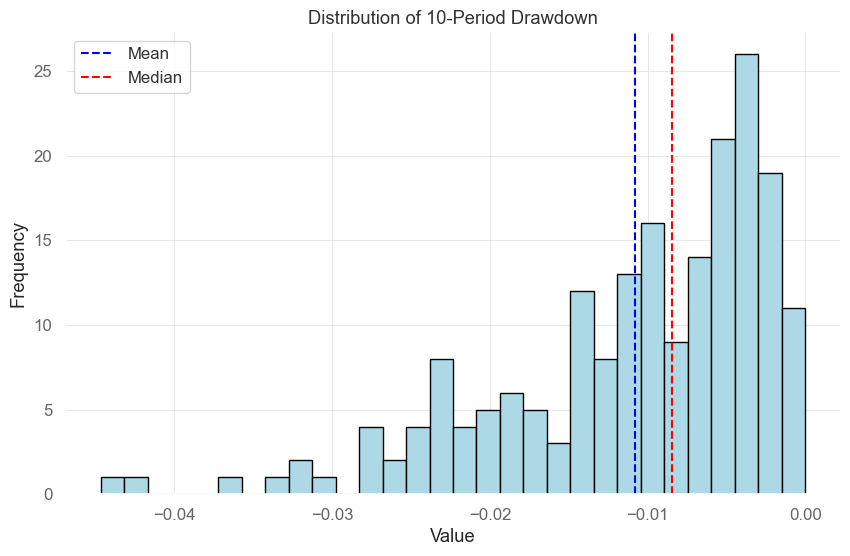

In [33]:
get_distribution(conditional_data['max_drawdown'], f'{lookahead}-Period Drawdown')

Mean :  0.010178838354375963
Standard Deviation :  0.011516355104417427


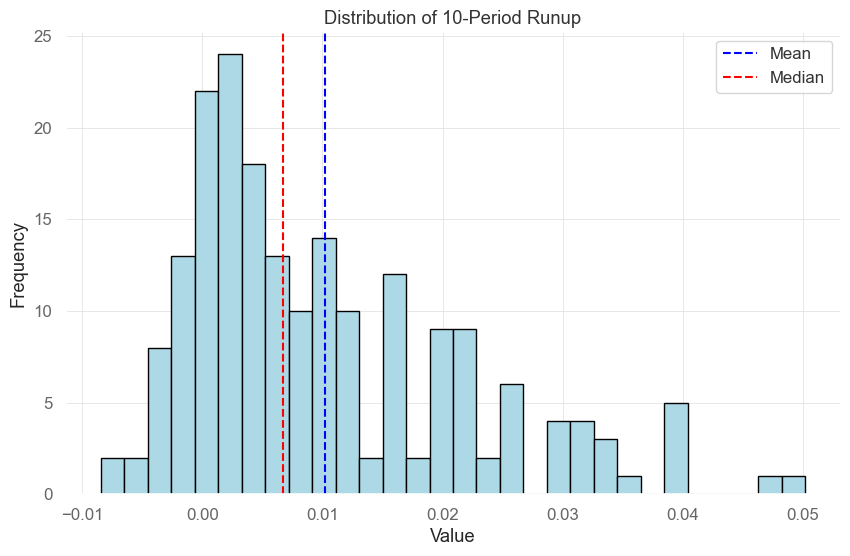

In [34]:
get_distribution(conditional_data['max_runup'], f'{lookahead}-Period Runup')

In [43]:
from scipy.stats import anderson, kstest

distr = ['norm', 'gumbel_l', 'gumbel_r', 'expon', 'logistic']

for dist in distr:
    ad_result = anderson(data['lookahead_return'], dist=dist) 
    print(f'\nAnderson-Darling Test: Ditribution - {dist}')
    print(' - Statistic:', ad_result.statistic)
    print(' - Critical Values:', ad_result.critical_values)


Anderson-Darling Test: Ditribution - norm
 - Statistic: 43.274261380076496
 - Critical Values: [0.576 0.656 0.787 0.918 1.092]

Anderson-Darling Test: Ditribution - gumbel_l
 - Statistic: 442.6129184885758
 - Critical Values: [0.473 0.636 0.756 0.876 1.037]

Anderson-Darling Test: Ditribution - gumbel_r
 - Statistic: 654.7220132668444
 - Critical Values: [0.473 0.636 0.756 0.876 1.037]

Anderson-Darling Test: Ditribution - expon
 - Statistic: inf
 - Critical Values: [0.922 1.078 1.341 1.606 1.957]

Anderson-Darling Test: Ditribution - logistic
 - Statistic: 4.1710069994514924
 - Critical Values: [0.426 0.563 0.66  0.769 0.906 1.01 ]
